<a href="https://colab.research.google.com/github/simpleParadox/RE_656/blob/main/CMPUT_656_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.0 MB/s 


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

In [ ]:
import tokenization

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import f1_score

In [ ]:
tf.__version__

'2.8.0'

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
relations_path = '/content/drive/Shareddrives/CMPUT 656 Data and Results/Processed Data/Input_500_29_relation.tsv'

Mounted at /content/drive


In [ ]:
train_data = pd.read_csv(relations_path, encoding='utf-8', sep = '\t')

In [ ]:
train_data.fillna("", inplace = True)

In [ ]:
# Shuffle data so that there is a higher chance of the train and test data being from the same distribution.
train_data = shuffle(train_data, random_state = 1)

In [ ]:
# Now read the rows, convert them into strings and then only keep the unique ones.
sentences_and_lables = np.array([[' '.join(map(str, row[:-1].tolist())).strip(), row[-1]] for row in train_data.iloc[:,:].values])
print(sentences_and_lables.shape)
sentences = sentences_and_lables[:, 0]
#labels = sentences_and_lables[:, 1]

(589617, 2)


In [ ]:
label = preprocessing.LabelEncoder()
y = label.fit_transform(train_data['relation'])
label_mappings = integer_mapping = {i: l for i, l in enumerate(label.classes_)}
# y = to_categorical(y) # doing this later.

In [ ]:
label_mappings

{0: 'None',
 1: 'award.award_nominated_work.award_nominations..award.award_nomination.award_nominee',
 2: 'book.author.works_written',
 3: 'book.book.genre',
 4: 'business.company.industry',
 5: 'education.educational_institution.students_graduates..education.educational_institution.students_graduates',
 6: 'film.actor.film..film.performance.character',
 7: 'film.director.film',
 8: 'film.film.country',
 9: 'film.film.genre',
 10: 'film.film.language',
 11: 'film.film.music',
 12: 'film.film.production_companies',
 13: 'film.performance.actor..film.performance.film',
 14: 'film.producer.film',
 15: 'film.writer.film',
 16: 'government.political_party.politicians_in_this_party',
 17: 'location.location.contains',
 18: 'music.artist.album',
 19: 'music.artist.origin',
 20: 'people.deceased_person.place_of_death',
 21: 'people.person.nationality',
 22: 'people.person.parents',
 23: 'people.person.place_of_birth',
 24: 'people.person.profession',
 25: 'people.person.religion',
 26: 'people

In [ ]:
print(y[:5])

[27  9 21  8 12]


In [ ]:
print(sentences[:5])

['Scorers and assistants Position Name DF  Marko Lomić Marko Lomić'
 'Short films Title Genre  Bramadero Bramadero  Erotic'
 'First Team Squad Name Nationality  Dídac Vilà Dídac Vilà  Spain'
 '2010s Film Country  Mother Mother 2009 film   South Korea South Korea'
 '2000s Film Studio(s)  Monster House Monster House film   Relativity Media Relativity Media ImageMovers ImageMovers and Amblin Entertainment Amblin Entertainment']


In [ ]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=False)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    print(tf.shape(sequence_output))
    clf_output = sequence_output[:, :, :]
    print(tf.shape(clf_output))
    
    lay = tf.keras.layers.Conv1D(filters=8, kernel_size=5, strides=1, padding="same", activation="relu")(clf_output)
    lay = tf.keras.layers.MaxPooling1D(2, 2)(lay)
    #lay = tf.keras.layers.LSTM(2, return_sequences=True, dropout=0.2)(lay)
    lay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True, dropout=0.2))(lay)
    lay = tf.keras.layers.Flatten()(lay)
    out = tf.keras.layers.Dense(29, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    #model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(tf.keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

### Obtaining Train, test splits.
###### In the train splits, we will have a separate validation split.

In [ ]:
checkpoint_path = "training_relations/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
def get_labels(y_pred):
    y_pred_label = np.zeros((len(y_pred),1))
    print(y_pred_label.shape)
    for index in range(len(y_pred)):
        y_pred_label[index] = np.argmax(y_pred[index])
    return y_pred_label

# Do not run the following cell if using checkpointed files.

In [ ]:
# with tf.device('/device:GPU:0'):
#     splits = 5 # For five fold cross-validation.
#     #seeds = [i for i in range(splits)]  # Fix the seed value for reproducibility.
#     seeds = [0] 
    
#     val_dict = {}
#     test_dict = {}

#     # First get random train-test splits. Doesn't include validation, which will be obtained from the train set.
#     for seed in seeds:
#         x_t, x_test, y_t, y_test = train_test_split(sentences, y, random_state=seed, test_size=0.2)   # Global training and test sets.

#         # Now get validation sets from each training set.
# #         kf = KFold(n_splits=5, shuffle=False) # Setting shuffle=False because shuffled dataset already before.
# #         fold_count = 0

# #         for train_index, val_index in kf.split(x_t):
# #             #print(x_t.shape)
# #             #print(y_t.shape)
# #             x_train, x_val = x_t[train_index], x_t[val_index]   # Training and validation features.
# #             y_train, y_val = y_t[train_index], y_t[val_index]   # Training and validation labels.

# #             #encode train data
# #             max_len = 80
# #             train_input = bert_encode(x_train, tokenizer, max_len=max_len)
# #             train_labels = y_train
# #             x_val = bert_encode(x_val, tokenizer, max_len=max_len)


# #             model = build_model(bert_layer, max_len=max_len)
# #             model.summary()
# #             #checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
# #             checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
# #             earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
# #             train_sh = model.fit(
# #             train_input, train_labels,
# #             #validation_split=0.2,
# #             validation_data=(x_val, y_val),
# #             epochs=2,
# #             callbacks=[checkpoint, earlystopping],
# #             batch_size=16,
# #             verbose=1)

# #             # Validation sets can be used for hyperparamter tuning.  
# #             val_dict[str(seed) + str(fold_count)] = train_sh.history
# #             fold_count += 1

#         #encode whole train data
#         max_len = 80
#         train_input = bert_encode(x_t, tokenizer, max_len=max_len)
#         train_labels = y_t
        
#         #train model on whole train data
#         model = build_model(bert_layer, max_len=max_len)
#         model.summary()
#         #checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
#         checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
#         earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)
#         train_sh = model.fit(
#         train_input, train_labels,
#         validation_split=0,
#         epochs=6,
#         callbacks=[checkpoint, earlystopping],
#         batch_size=16,
#         verbose=1)

#         #encode test data 
#         test_input = bert_encode(x_test, tokenizer, max_len=max_len)

#         # Evaluate the model on the test data using `evaluate`
#         print("Evaluate on test data for ", seed)
#         results = model.evaluate(test_input, y_test, batch_size=16)

#         #calculate F1-score
#         y_pred = model.predict(test_input, verbose=1)
#         y_pred_label = get_labels(y_pred)
#         f1_value = f1_score(y_test, y_pred_label, average='macro')
#         results.append(f1_value)
#         print("test loss, test acc, F1-score:", results)

#         test_dict[seed] = results

In [ ]:
# with open('results seed=0 batch_size=16.txt','w') as data: 
#     data.write(str(val_dict))
#     data.write('\n')
#     data.write(str(test_dict))

## The following section is for loading the checkpoint weights and then obtaining the confusion matrix.

In [ ]:
cms = []

In [ ]:
#code for loading weights from checkpoint
with tf.device('/device:GPU:0'):
    results = []
    splits = 5 # For five fold cross-validation.
    #seeds = [i for i in range(splits)]  # Fix the seed value for reproducibility.
    seeds = [4]#0, 1, 2, 3, 4]
    
    val_dict = {}
    test_dict = {}
    
    # First get random train-test splits. Doesn't include validation, which will be obtained from the train set.
    for seed in seeds:
        x_t, x_test, y_t, y_test = train_test_split(sentences, y, random_state=seed, test_size=0.2)   # Global training and test sets.

        # Evaluate the new model
        max_len = 80
        new_model = build_model(bert_layer, max_len=max_len)
        new_model.summary()
        # Loads the weights for new model
        checkpoint_path = f"/content/drive/Shareddrives/CMPUT 656 Data and Results/Result 29 Relations/Seed {seed}/training_relations/cp.ckpt"
        training_relations_path = f"/content/drive/Shareddrives/CMPUT 656 Data and Results/Result 29 Relations/Seed {seed}/training_relations/"
        # /content/drive/Shareddrives/CMPUT 656 Data and Results/Result 29 Relations/Seed 0/training_relations/cp.ckpt.data-00000-of-00001
        

        new_model.load_weights(checkpoint_path)

        #encode test data
        test_input = bert_encode(x_test, tokenizer, max_len=max_len)

        # Evaluate the model on the test data using `evaluate`
        print("Evaluate on test data for ", seed)
        # results = new_model.evaluate(test_input, y_test, batch_size=16)

        #calculate F1-score
        y_pred = new_model.predict(test_input, batch_size=16, verbose=1)
        y_pred_label = get_labels(y_pred)
        f1_value = f1_score(y_test, y_pred_label, average='macro')
        np.savez_compressed(training_relations_path +  "predictions.npz", y_pred_label)
        cm = confusion_matrix(y_pred_label, y_test, labels=[i for i in label_mappings.keys()])
        cms.append(cm)

        results.append(f1_value)
        print("Test loss, Test acc, F1-score:", results)

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 80, 768], name='tf.compat.v1.shape/Shape:0', description="created by layer 'tf.compat.v1.shape'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 80, 768], name='tf.compat.v1.shape_1/Shape:0', description="created by layer 'tf.compat.v1.shape_1'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 80)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 80)]         0           []                               
                                                                                                  
 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Evaluate on test data for  4
7371/7371 [==============================] - 1525s 205ms/step
(117924, 1)
Test loss, Test acc, F1-score: [0.9598390948915099]


In [ ]:
for k, v in label_mappings.items():
    print(k, v)

0 None
1 award.award_nominated_work.award_nominations..award.award_nomination.award_nominee
2 book.author.works_written
3 book.book.genre
4 business.company.industry
5 education.educational_institution.students_graduates..education.educational_institution.students_graduates
6 film.actor.film..film.performance.character
7 film.director.film
8 film.film.country
9 film.film.genre
10 film.film.language
11 film.film.music
12 film.film.production_companies
13 film.performance.actor..film.performance.film
14 film.producer.film
15 film.writer.film
16 government.political_party.politicians_in_this_party
17 location.location.contains
18 music.artist.album
19 music.artist.origin
20 people.deceased_person.place_of_death
21 people.person.nationality
22 people.person.parents
23 people.person.place_of_birth
24 people.person.profession
25 people.person.religion
26 people.person.spouse_s..people.marriage.spouse
27 soccer.football_position.players
28 sports.sports_team.roster..sports.sports_team_roster.

In [ ]:
reduced_label_mappings = {
    0: 'None',
    1: 'award=nominee',
    2: 'author-works_written',
    3: 'book-genre',
    4: 'company-industry',
    5: 'person-graduate',
    6: 'actor-character',
    7: 'director-film',
    8: 'film-country',
    9: 'film-genre',
    10: 'film-language',
    11: 'film-music',
    12: 'film-production_company',
    13: 'actor-film',
    14: 'producer-film',
    15: 'writer-film',
    16: 'political_party-politician',
    17: 'location-contains',
    18: 'musician-album',
    19: 'musician-origin',
    20: 'person-place_of_death',
    21: 'person-nationality',
    22: 'person-parents',
    23: 'person-place_of_birth',
    24: 'person-profession',
    25: 'person-religion',
    26: 'person-spouse',
    27: 'football_position-player',
    28: 'sports_team-player'
}

# Read in all the predictions for different seeds and make a confusion matrix by averaging them together. 

NOTE: The confusion matrix is normalized.

In [ ]:
cms = []
seeds = [0, 1, 2, 3, 4]
for seed in seeds:
    training_relations_path = f"/content/drive/Shareddrives/CMPUT 656 Data and Results/Result 29 Relations/Seed {seed}/training_relations/"
    x_t, x_test, y_t, y_test = train_test_split(sentences, y, random_state=seed, test_size=0.2)
    del x_t
    del x_test
    del y_t
    predictions = np.load(training_relations_path + "predictions.npz", allow_pickle=True)['arr_0'].tolist()
    cms.append(confusion_matrix(predictions, y_test, labels=[i for i in label_mappings.keys()]))



<Figure size 432x288 with 0 Axes>

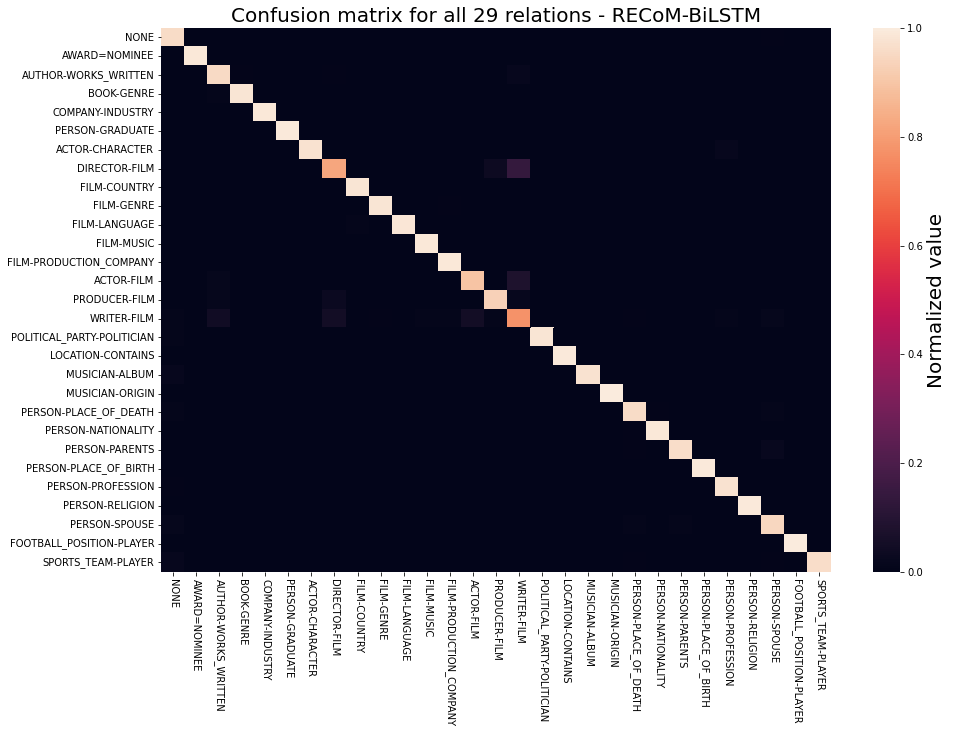

In [ ]:
plt.clf()
averaged_cms = np.mean(cms, axis=0)
averaged_cms = averaged_cms.astype('float') / averaged_cms.sum(axis=1)[:, np.newaxis]
cms_df = pd.DataFrame(averaged_cms, index = [value for value in reduced_label_mappings.values()],
                      columns=[value for value in reduced_label_mappings.values()])
fig, ax = plt.subplots(figsize=(15, 10))
heat = sns.heatmap(cms_df, vmin=0.0, vmax=1.0, cbar_kws={'label': 'Normalized value'})
heat.figure.axes[-1].yaxis.label.set_size(20)
yticks = [i.upper() for i in cms_df.index]
xticks = [i.upper() for i in cms_df.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks, rotation=270)
plt.title("Confusion matrix for all 29 relations - CoMemNet-BiLSTM", fontsize=20)

plt.show()

In [ ]:
cm = confusion_matrix(y_pred_label, y_test, labels=[i for i in label_mappings.keys()])
cms.append(cm)

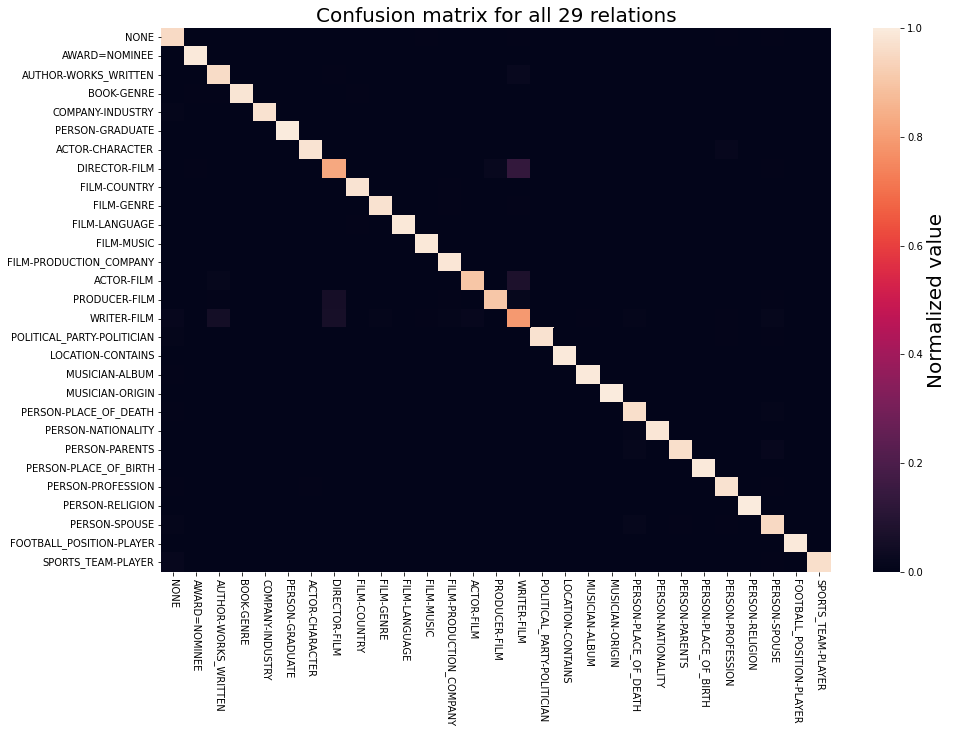

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
averaged_cms = np.mean(cms, axis=0)
averaged_cms = averaged_cms.astype('float') / averaged_cms.sum(axis=1)[:, np.newaxis]
cms_df = pd.DataFrame(averaged_cms, index = [value for value in reduced_label_mappings.values()],
                      columns=[value for value in reduced_label_mappings.values()])
fig, ax = plt.subplots(figsize=(15, 10))
heat = sns.heatmap(cms_df, vmin=0.0, vmax=1.0, cbar_kws={'label': 'Normalized value'})
heat.figure.axes[-1].yaxis.label.set_size(20)
yticks = [i.upper() for i in cms_df.index]
xticks = [i.upper() for i in cms_df.columns]
plt.yticks(plt.yticks()[0], labels=yticks, rotation=0)
plt.xticks(plt.xticks()[0], labels=xticks, rotation=270)
plt.title("Confusion matrix for all 29 relations", fontsize=20)

plt.show()

In [ ]:

averaged_cms.shape

(29, 29)

# Gradio app to demo the model.

In [8]:
!pip install -q gradio
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 13.9 MB/s 


In [9]:
import tokenization
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
import gradio as gr

In [10]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=False)

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
def get_labels(y_pred):
    y_pred_label = np.zeros((len(y_pred),1))
    print(y_pred_label.shape)
    for index in range(len(y_pred)):
        y_pred_label[index] = np.argmax(y_pred[index])
    return y_pred_label

In [12]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [13]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    print(tf.shape(sequence_output))
    clf_output = sequence_output[:, :, :]
    print(tf.shape(clf_output))
    
    lay = tf.keras.layers.Conv1D(filters=8, kernel_size=5, strides=1, padding="same", activation="relu")(clf_output)
    lay = tf.keras.layers.MaxPooling1D(2, 2)(lay)
    #lay = tf.keras.layers.LSTM(2, return_sequences=True, dropout=0.2)(lay)
    lay = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8, return_sequences=True, dropout=0.2))(lay)
    lay = tf.keras.layers.Flatten()(lay)
    out = tf.keras.layers.Dense(29, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    #model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    #model.compile(tf.keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [41]:
reduced_label_mappings = {
    0: 'None',
    1: 'award-nominee',
    2: 'author-works_written',
    3: 'book-genre',
    4: 'company-industry',
    5: 'person-graduate',
    6: 'actor-character',
    7: 'director-film',
    8: 'film-country',
    9: 'film-genre',
    10: 'film-language',
    11: 'film-music',
    12: 'film-production_company',
    13: 'actor-film',
    14: 'producer-film',
    15: 'writer-film',
    16: 'political_party-politician',
    17: 'location-contains',
    18: 'musician-album',
    19: 'musician-origin',
    20: 'person-place_of_death',
    21: 'person-nationality',
    22: 'person-parents',
    23: 'person-place_of_birth',
    24: 'person-profession',
    25: 'person-religion',
    26: 'person-spouse',
    27: 'football_position-player',
    28: 'sports_team-player'
}

In [15]:
# with tf.device('/device:GPU:0'):
#     results = []
#     splits = 5 # For five fold cross-validation.
#     #seeds = [i for i in range(splits)]  # Fix the seed value for reproducibility.
#     seeds = [4]#0, 1, 2, 3, 4]
    
#     val_dict = {}
#     test_dict = {}
    
#     # First get random train-test splits. Doesn't include validation, which will be obtained from the train set.
#     for seed in seeds:
#         x_t, x_test, y_t, y_test = train_test_split(sentences, y, random_state=seed, test_size=0.2)   # Global training and test sets.

#         # Evaluate the new model
#         max_len = 80
#         new_model = build_model(bert_layer, max_len=max_len)
#         new_model.summary()
#         # Loads the weights for new model
#         checkpoint_path = f"/content/drive/Shareddrives/CMPUT 656 Data and Results/Result 29 Relations/Seed {seed}/training_relations/cp.ckpt"
#         training_relations_path = f"/content/drive/Shareddrives/CMPUT 656 Data and Results/Result 29 Relations/Seed {seed}/training_relations/"
#         # /content/drive/Shareddrives/CMPUT 656 Data and Results/Result 29 Relations/Seed 0/training_relations/cp.ckpt.data-00000-of-00001
        

#         new_model.load_weights(checkpoint_path)

#         #encode test data
#         test_input = bert_encode(x_test, tokenizer, max_len=max_len)

#         # Evaluate the model on the test data using `evaluate`
#         print("Evaluate on test data for ", seed)
#         # results = new_model.evaluate(test_input, y_test, batch_size=16)

#         #calculate F1-score
#         y_pred = new_model.predict(test_input, batch_size=16, verbose=1)
#         y_pred_label = get_labels(y_pred)
#         f1_value = f1_score(y_test, y_pred_label, average='macro')
#         np.savez_compressed(training_relations_path +  "predictions.npz", y_pred_label)
#         cm = confusion_matrix(y_pred_label, y_test, labels=[i for i in label_mappings.keys()])
#         cms.append(cm)

#         results.append(f1_value)
#         print("Test loss, Test acc, F1-score:", results)

In [26]:
seed = 0
checkpoint_path = f"/content/drive/Shareddrives/CMPUT 656 Data and Results/Result 29 Relations/Seed {seed}/training_relations/cp.ckpt"
max_len = 80

new_model = build_model(bert_layer, max_len=max_len)
new_model.load_weights(checkpoint_path)

KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 80, 768], name='tf.compat.v1.shape_8/Shape:0', description="created by layer 'tf.compat.v1.shape_8'")
KerasTensor(type_spec=TensorSpec(shape=(3,), dtype=tf.int32, name=None), inferred_value=[None, 80, 768], name='tf.compat.v1.shape_9/Shape:0', description="created by layer 'tf.compat.v1.shape_9'")


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [50]:
def predict_relation(sentence):
    print(sentence)
    # df = pd.DataFrame.from_dict(
    #     {
    #         "Pclass": [passenger_class + 1],
    #         "Sex": [0 if is_male else 1],
    #         "Age": [age],
    #         "Company": [
    #             (1 if "Sibling" in company else 0) + (2 if "Child" in company else 0)
    #         ],
    #         "Fare": [fare],
    #         "Embarked": [embark_point + 1],
    #     }
    # )
    
    test_input = bert_encode(np.array([sentence]), tokenizer, max_len=max_len)
    y_pred = new_model.predict(test_input, batch_size=16, verbose=1)
    y_pred_label = get_labels(y_pred)
    relations = [rel for rel in reduced_label_mappings.values()]
    probabilities = y_pred.tolist()[0]
    result_dict = {}
    for k, v in zip(relations, probabilities):
        result_dict[k] = v
    return result_dict
    # return y_pred_label, y_pred

In [ ]:
# [rel for rel in reduced_label_mappings.values()]

In [51]:
predict_relation("Avatar was directed by James")

Avatar was directed by James
1/1 [==============================] - 0s 379ms/step
(1, 1)


{'None': 0.026813292875885963,
 'actor-character': 0.039414212107658386,
 'actor-film': 0.0014545839512720704,
 'author-works_written': 0.00037750325282104313,
 'award-nominee': 2.0406776457093656e-05,
 'book-genre': 6.763075816706987e-06,
 'company-industry': 5.830914233229123e-06,
 'director-film': 0.2887896001338959,
 'film-country': 0.0017016256460919976,
 'film-genre': 0.0005461295368149877,
 'film-language': 0.06926463544368744,
 'film-music': 0.15396985411643982,
 'film-production_company': 0.011293824762105942,
 'football_position-player': 5.903470992052462e-07,
 'location-contains': 0.00040040144813247025,
 'musician-album': 9.624188533052802e-05,
 'musician-origin': 0.025806942954659462,
 'person-graduate': 7.092034502420574e-05,
 'person-nationality': 5.947429713160091e-07,
 'person-parents': 5.087800332148618e-07,
 'person-place_of_birth': 3.1900417525321245e-06,
 'person-place_of_death': 0.0002447587321512401,
 'person-profession': 0.01602892391383648,
 'person-religion': 

In [53]:
iface = gr.Interface(
    predict_relation,
    inputs="text",
    outputs="label",
    interpretation="default",
    title="CoMemNet - Relation Extractor", description="NOTE: Model is trained on Wikipedia table data and not continuous text."
)

iface.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://30032.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.


(<fastapi.applications.FastAPI at 0x7f1bc4e32850>,
 'http://127.0.0.1:7861/',
 'https://30032.gradio.app')

In [55]:
!git clone https://huggingface.co/spaces/simpleParadox/RE_656

Cloning into 'RE_656'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 1), reused 0 (delta 0)
Unpacking objects: 100% (7/7), done.
